In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pyroomacoustics as pra
import noisereduce as nr
from pyroomacoustics.directivities import (
    DirectivityPattern,
    DirectionVector,
    CardioidFamily,
)
from pyroomacoustics.doa import circ_dist
from scipy.io import wavfile
from scipy.signal import correlate
from scipy.fft import fft, fftfreq, fftshift
from playsound import playsound
from os import listdir
from os.path import isfile, join

/opt/miniconda3/envs/myenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
playsound is relying on a python 2 subprocess. Please use `pip3 install PyObjC` if you want playsound to run more efficiently.


In [113]:
# read in signals from gridpoint
audio_file_path = "/Users/nharrison/DOA_Testing/y=4,x=-2/"
file = "/Users/nharrison/DOA_Testing/Room/1.wav"
fs, noise = wavfile.read(file)
for signalindex in range(1,8+1):
    file = audio_file_path + str(signalindex) + ".wav"
    fs, signal = wavfile.read(file)
    denoised = nr.reduce_noise(y=signal,sr=fs,y_noise=noise)
    if signalindex == 1:
        signals = np.zeros((8, len(signal)))
        denoised_signals = np.zeros((8, len(signal)))

    signals[signalindex-1, :] = signal
    denoised_signals[signalindex-1,:] = denoised
    wavfile.write("/Users/nharrison/denoised"+str(signalindex)+".wav", fs, denoised)



/var/folders/4t/rx6h__y129d95fxhwcb9st6w0000gn/T/ipykernel_6874/621083609.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, noise = wavfile.read(file)
/var/folders/4t/rx6h__y129d95fxhwcb9st6w0000gn/T/ipykernel_6874/621083609.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, signal = wavfile.read(file)


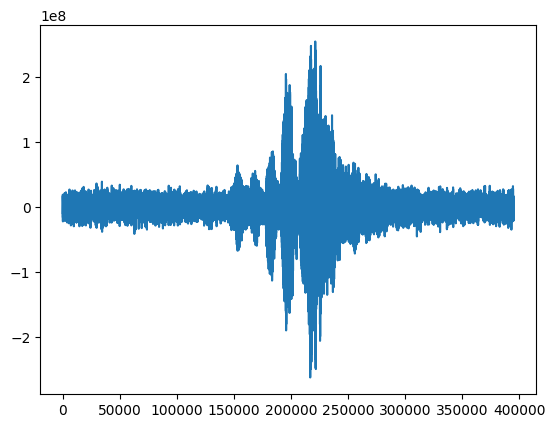

In [120]:
# find start of signal of interest
plt.plot(signals[1,:])
# signal at 150000
nfft=1024
package = signals[:,150000:150000+10*nfft]
package = np.array(
    [
        np.divide(channel,np.sqrt(np.var(channel)))
        for channel in package
    ]
)
#plt.plot(package[1,:])
#plt.plot(package[2,:])


In [121]:
# try normMUSIC with middle two microphones

# make array
array_loc = [0, 0]
sep = -0.3
R = pra.linear_2D_array(center=array_loc, M=4, phi=0, d=sep)

# define frequency range
flow =500
fhigh =800

# take stft transform of package
X = pra.transform.stft.analysis(package.T, nfft, nfft//2).T
print(X.shape)


# initialise doa object
music = pra.doa.normmusic.NormMUSIC(R, fs, nfft,num_src=1,azimuth = np.linspace(0, 180, 181)*np.pi/180,mode='near')
music.locate_sources(X[2:6,:,:],freq_range = [flow,fhigh])


(8, 513, 20)


[117.]


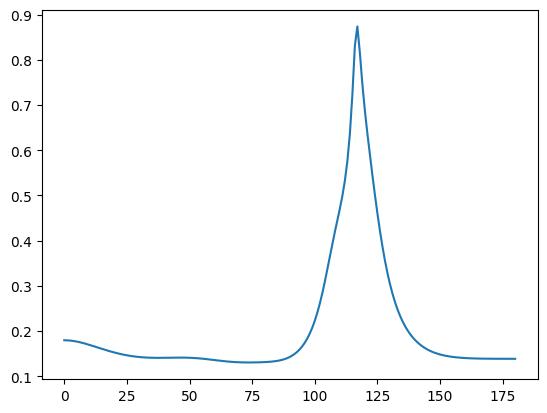

In [122]:
print(music.azimuth_recon*180/np.pi)
plt.plot(music.grid.azimuth*180/np.pi,music.grid.values)
cardioid = 0.5+0.5*np.cos(music.grid.azimuth-np.pi/2)
#plt.plot(music.grid.values/cardioid)

[94.]
[95.]
[97.]
[99.]
[98.]
[98.]
[99.]
[101.]
[98.]
[98.]
[97.]
[97.]
[94.]
[94.]
[93.]
[94.]
[95.]
[96.]
[96.]
[96.]
[96.]
[96.]
[97.]
[97.]
[97.]
[96.]
[96.]
[96.]
[95.]
[95.]
[95.]
[94.]
[94.]
[95.]
[96.]
[96.]
[96.]
[96.]
[96.]
[97.]
[97.]
[95.]
[91.]
[90.]
[88.]
[87.]
[88.]
[94.]
[88.]
[88.]
[90.]
[92.]
[93.]
[95.]
[97.]
[96.]
[95.]
[94.]
[94.]
[94.]
[95.]
[96.]
[94.]
[97.]
[95.]
[93.]
[92.]
[92.]
[98.]
[116.]
[117.]
[117.]
[117.]
[117.]
[117.]
[113.]
[105.]
[104.]
[111.]
[109.]
[109.]
[110.]
[106.]
[119.]
[116.]
[117.]
[116.]
[116.]
[118.]
[118.]
[119.]
[119.]
[117.]
[118.]
[118.]
[117.]
[116.]
[120.]
[116.]
[117.]
[116.]
[118.]
[120.]
[120.]
[118.]
[117.]
[120.]
[123.]
[122.]
[122.]
[122.]
[122.]
[120.]
[121.]
[119.]
[114.]
[108.]
[110.]
[110.]
[117.]
[117.]
[118.]
[119.]
[119.]
[118.]
[116.]
[117.]
[114.]
[114.]
[113.]
[112.]
[111.]
[110.]
[109.]
[108.]
[109.]
[110.]
[110.]
[110.]
[111.]
[111.]
[112.]
[111.]
[111.]
[109.]
[112.]
[99.]
[102.]
[104.]
[103.]
[99.]
[102.]
[101.]

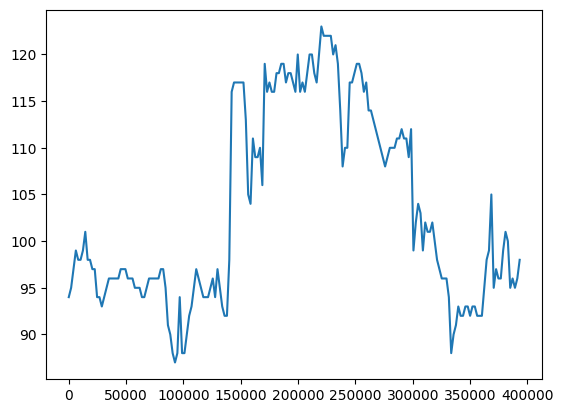

In [123]:
# now try a moving package


step = 2*nfft
nsamples = signals.shape[1]
numpackages = nsamples//step
azs = np.zeros(numpackages)
for i in range(numpackages):
    package = signals[2:6,i*step:10*nfft+i*step]
    # normalise package
    package = np.array(
        [
            np.divide(channel,np.sqrt(np.var(channel)))
            for channel in package
        ]
               
    )
    X = pra.transform.stft.analysis(package.T, nfft, nfft//2).T
    music.locate_sources(X,freq_range = [flow,fhigh])
    print(music.azimuth_recon*180/np.pi)
    azs[i] = music.azimuth_recon*180/np.pi

plt.plot(np.linspace(0, numpackages*step, numpackages),azs)